In [1]:
# Staple  
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns

# Misc  
import re  
import itertools  
import os  
import joblib  
from tqdm.notebook import tqdm  
from IPython.display import HTML
import pickle
import os
import sys
import time

# NLP  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize, RegexpTokenizer  
from nltk.stem.snowball import SnowballStemmer  
from nltk.stem import PorterStemmer, WordNetLemmatizer  
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy

# Clustering  
from sklearn.decomposition import PCA, TruncatedSVD  
from sklearn.cluster import (KMeans,  AgglomerativeClustering,  
                             DBSCAN, OPTICS, cluster_optics_dbscan)  
from pyclustering.cluster.kmedoids import kmedoids
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (silhouette_score, calinski_harabasz_score, 
                             davies_bouldin_score,)

# hyperparameter tuning
from yellowbrick.cluster.elbow import kelbow_visualizer
from kneed import KneeLocator

import sqlite3
# import plotly.express.px

# fast cluster
import fastcluster

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lptv36gc because the default path (/home/nlim/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2023-02-08 11:52:13.013437: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-08 11:52:13.013486: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jupyter-nlim
2023-02-08 11:52:13.013499: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jupyter-nlim
2023-02-08 11:52:13.013604: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-02-08 11:52:13.013646: I tensorflow/

In [18]:
def save_pkl(obj, name, prompt=False):
    
    """Save an object to a pickle file."""
    
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        os.makedirs(folder)
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    joblib.dump(obj, fp)
    if prompt:
        print('Object pickled for future use.')
    return

In [19]:
def load_pkl(obj, name):
    
    """Load an object from a pickle file."""
    
    folder = 'pickles'
    ext = '.pkl'
    if not os.path.exists(folder):
        raise ValueError("'pickles' folder does not exist.")
    if name[-4:] == ext:
        fp = os.path.join(folder, name)
    else:
        fp = os.path.join(folder, name+ext)
    return joblib.load(fp)

## Importing database

In [4]:
db_path = '/mnt/processed/private/msds2023/slt5a/lab1/ssot/amazon.db'  
conn = sqlite3.connect(db_path)

In [5]:
amz_dict = {}

for date in ['2012-12', '2013-12' ,'2014-12']:
    query = f"""
        SELECT * 
        FROM amazon_main  
        WHERE review_date LIKE '%{date}%'
        """
    amz_dict.update({int(date[:4]): pd.read_sql(query, conn)})

In [6]:
amz_2012 = amz_dict[2012]

In [33]:
amz_2012.head()

,review_id,customer_id,product_id,product_title,star_rating,review_headline,review_body
review_date,,,,,,,
2014-12-31,R23K7QNHEMI5Q9,12450911,B003D0WM8W,Chocolate River Stones (1lb Bag),5,Five Stars,Always a huge hit!
2014-12-31,R11CMHYGHB0HIE,8428967,B001C316QG,"Dave's Gourmet Ultimate Insanity Hot Sauce, 5-...",5,Five Stars,It is great for injecting Turkey
2014-12-31,RFTDF0NVS3PZZ,53006884,B001SAZJ6G,Krusteaz Fat Free Honey Cornbread Mix,5,"great taste, not too sweet",Our favorite cornbread mix. It makes Jiffy loo...
2014-12-31,R32HWAQGG98HZA,49830587,B00HZ492I0,Hot & Spicy SPAM 12 oz (3 pack),5,YUM!,Who knew there were so many tasty versions of ...
2014-12-31,RILQIU9SIQUV1,12824071,B00GHR5C0S,"Honduran Marcala OFT Coffee, Whole Bean Coffee...",4,I love this coffee co,"I love this coffee co., and this coffee is goo..."


In [19]:
amz_2012.set_index('review_date', inplace=True)
amz_2012.head()

,review_id,customer_id,product_id,product_title,star_rating,review_headline,review_body
review_date,,,,,,,
2014-12-31,R23K7QNHEMI5Q9,12450911,B003D0WM8W,Chocolate River Stones (1lb Bag),5,Five Stars,Always a huge hit!
2014-12-31,R11CMHYGHB0HIE,8428967,B001C316QG,"Dave's Gourmet Ultimate Insanity Hot Sauce, 5-...",5,Five Stars,It is great for injecting Turkey
2014-12-31,RFTDF0NVS3PZZ,53006884,B001SAZJ6G,Krusteaz Fat Free Honey Cornbread Mix,5,"great taste, not too sweet",Our favorite cornbread mix. It makes Jiffy loo...
2014-12-31,R32HWAQGG98HZA,49830587,B00HZ492I0,Hot & Spicy SPAM 12 oz (3 pack),5,YUM!,Who knew there were so many tasty versions of ...
2014-12-31,RILQIU9SIQUV1,12824071,B00GHR5C0S,"Honduran Marcala OFT Coffee, Whole Bean Coffee...",4,I love this coffee co,"I love this coffee co., and this coffee is goo..."


In [20]:
amz_2012.describe()

,customer_id
count,9.098800e+04
mean,2.834923e+07
std,1.537023e+07
min,1.029300e+04
25%,1.486500e+07
50%,2.748116e+07
75%,4.277075e+07
max,5.309636e+07


In [8]:
amz_2012.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 2014-12-31 to 2014-12-15
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_id        50000 non-null  object
 1   customer_id      50000 non-null  int64 
 2   product_id       50000 non-null  object
 3   product_title    50000 non-null  object
 4   star_rating      50000 non-null  object
 5   review_headline  50000 non-null  object
 6   review_body      50000 non-null  object
dtypes: int64(1), object(6)
memory usage: 3.1+ MB


Filter dataset by date

## EDA

## Text preprocessing
- [x] Lowercasing
- [x] Removing punctuation, whitespaces, numbers
- [x] Removing other specific text patterns
- [x] Removing stop words
- [x] Stemming or lemmatization

In [23]:
prod_titles_2012 = amz_2012[['product_title']]

In [24]:
spacy_en_model = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
spacy_en_model.max_length = 4000000
def clean_text_spacy(text):
    processed_text = spacy_en_model(text)
    lemmas = [w.lemma_ if w.lemma_ != '-PRON-'
    else w.lower_ for w in processed_text
    if w.is_alpha and not w.is_stop]
    return ' '.join(lemmas).lower()


In [25]:
try:
    df_lemmatized_prod_title_2012 = load_pkl('df_lemmatized_prod_title_2012.pkl')

except:
    lemmatized_prod_title_2012 = prod_titles_2012['product_title'].apply(lambda x: clean_text_spacy(x))
    df_lemmatized_prod_title_2012 = pd.DataFrame(lemmatized_prod_title_2012)
    save_pkl(df_lemmatized_prod_title_2012, 'df_lemmatized_prod_title_2012.pkl')

Vectorize titles

In [8]:
import nltk
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/msds2023/nlim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
additional_stop_words = {'ounce', 'oz', 'lb', 'pound', 'Ounce'}

stops.update(additional_stop_words)


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=stops, ngram_range=(1, 1), 
                             min_df=10, max_df=0.9, 
                             token_pattern=r'[A-z]{2,}')

In [28]:
params = dict(
    stop_words=stops, 
    ngram_range=(1, 1), 
    min_df=10, max_df=0.9, 
    token_pattern=r'[A-z]{2,}'
)

In [29]:
def vectorize(corpus, model, params):
    """
    Vectorize the corpus of articles using `model`.
    """
    vectorizer = model(**params)
    sparse_corpus = vectorizer.fit_transform(corpus)
    corpus_df = pd.DataFrame.sparse.from_spmatrix(sparse_corpus, columns=vectorizer.get_feature_names_out())
    return corpus_df, sparse_corpus

In [30]:
try:
    prod_title_d_matrix_2012 = load_pkl('prod_title_d_matrix2012.pkl')

except:
    prod_title_d_matrix_2012, pd_sparse_2012 = vectorize(df_lemmatized_prod_title_2012['product_title'], TfidfVectorizer, params)
    save_pkl(prod_title_d_matrix_2012, 'prod_title_d_matrix2012.pkl')
    save_pkl(pd_sparse_2012, 'pd_sparse_2012.pkl')

In [31]:
prod_title_d_matrix_2012

,aa,abbey,absolutely,acai,accoutrement,acid,active,add,added,advent,...,zamouri,zatarain,zealand,zen,zero,zevia,zhena,zico,zipfizz,zotz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36447,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
prod_title_d_matrix_2012.sum().sort_values(ascending=False)[:30]

## KMeans Clustering

### Finding candidates for the best `k` value

In [32]:
prod_models_2012 = {}
prod_title_scores_2012 = {'sse': [], 'ch': [], 'sh': [], 'db': []}

for k in tqdm(range(2, 11)):
    kmeans = KMeans(n_clusters=k, random_state=1337)
    cluster_labels = kmeans.fit_predict(prod_title_d_matrix_2012)
    prod_models_2012.update({k: {
        'model': kmeans,
        'labels': cluster_labels,
    }})
    prod_title_scores_2012['sse'].append(kmeans.inertia_)
    prod_title_scores_2012['ch'].append(calinski_harabasz_score(
        prod_title_d_matrix_2012.to_numpy(),
        cluster_labels
    ))
    # prod_title_scores_2012['sh'].append(silhouette_score(
    #     prod_title_d_matrix_2012.to_numpy(), cluster_labels
    # ))
    prod_title_scores_2012['db'].append(davies_bouldin_score(
        prod_title_d_matrix_2012.to_numpy(), cluster_labels
    ))
    
save_pkl(prod_models_2012, 'prod_models_2012.pkl')
save_pkl(prod_title_scores_2012, 'prod_title_scores_2012.pkl')

  0%|          | 0/9 [00:00<?, ?it/s]

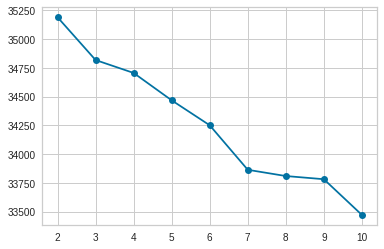

In [33]:
plt.plot(range(2, 11), prod_title_scores_2012['sse'], marker='o', label='sse')

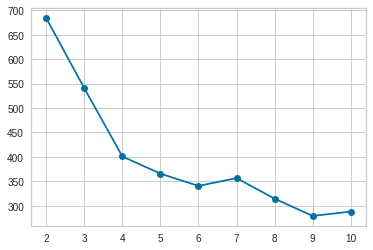

In [34]:
plt.plot(range(2, 11), prod_title_scores_2012['ch'], marker='o', label='ch')

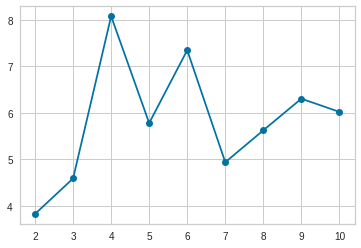

In [35]:
plt.plot(range(2, 11), prod_title_scores_2012['db'], marker='o', label='db')

In [22]:
# do not run the cell below

In [98]:
# k-means clustering

sum_of_squared_distances = []
K = range(2, 20)

for k in K:
    start_time = time.time()
    km = KMeans(n_clusters=k, max_iter=600, n_init=10)
    km.fit(prod_title_d_matrix_2012)
    sum_of_squared_distances.append(km.inertia_)
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'elbowPlot_runtime_dec2012.pkl')

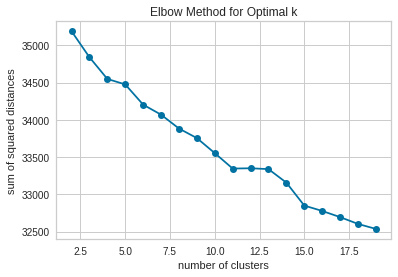

In [99]:
plt.plot(K, sum_of_squared_distances, '-o')
plt.xlabel('number of clusters')
plt.ylabel('sum of squared distances')
plt.title('Elbow Method for Optimal k')
plt.savefig('img/ElbowPlot_dec2012.png')
plt.show()

Warning: the `kelbowvisualizer` might take forever...

Metric = distortion or WCSS

In [100]:
dense_2012 = prod_title_d_matrix_2012.sparse.to_dense()

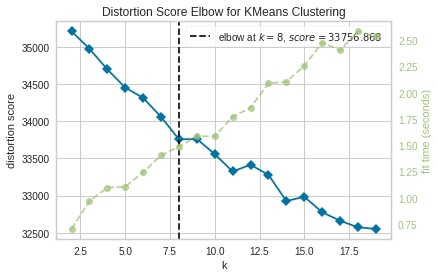

<Figure size 432x288 with 0 Axes>

In [101]:
try:
    start_time = time.time()
    viz = kelbow_visualizer(KMeans(), prod_title_d_matrix_2012, k=(2, 20))
    viz.show(outpath='img/DistortionScoreElbowPlot_dec2012.png')
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'DistortionScoreElbowPlot_runtime_dec2012.pkl')

except MemoryError():
    sys.exit()

Metric = silhouette

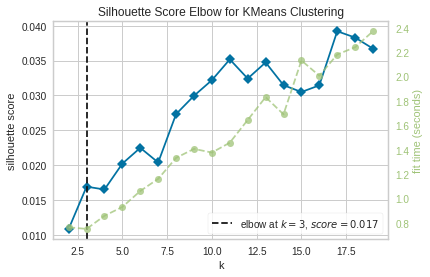

<Figure size 432x288 with 0 Axes>

In [102]:
try:
    start_time = time.time()
    viz = kelbow_visualizer(KMeans(), prod_title_d_matrix_2012, k=(2, 20),
                            metric='silhouette')
    viz.show(outpath='img/SilhouetteScoreElbowPlot_dec2012.png')
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'SilhouetteElbowPlot_runtime_dec2012')

except MemoryError():
    sys.exit()

Metric = calinski-harabasz

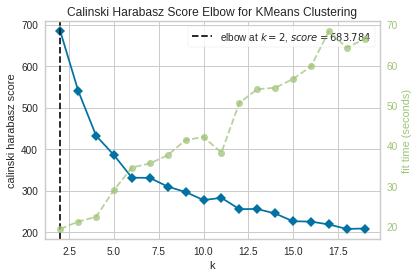

<Figure size 432x288 with 0 Axes>

In [103]:
try:
    start_time = time.time()
    viz = kelbow_visualizer(KMeans(), dense_2012, k=(2, 20),
                      metric='calinski_harabasz')
    viz.show(outpath='img/CalinskiHarabaszScoreElbowPlot_dec2012.png')
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'CalinskiHarabaszElbowPlot_runtime_dec2012')
    
except MemoryError():
    sys.exit()

The candidates for the best k-value were `9`, `7` and `2`, using the parameters `metric='distortion'`, `metric='silhouette'`, and `metric='calinski_harabasz'` respectively.

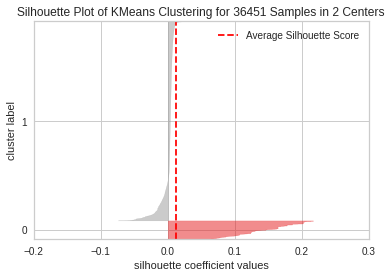

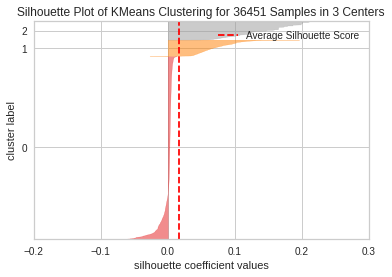

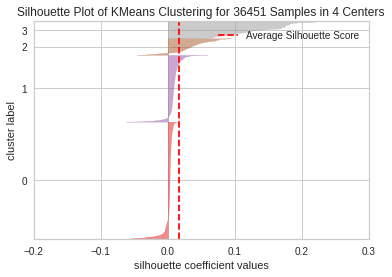

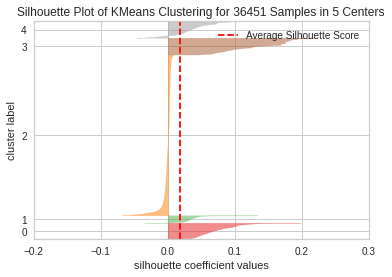

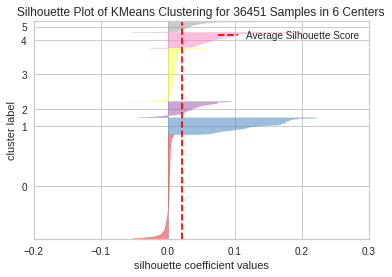

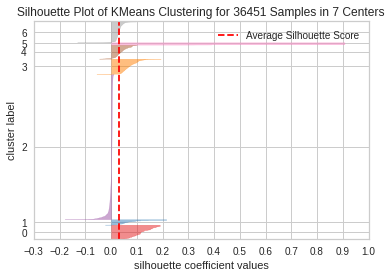

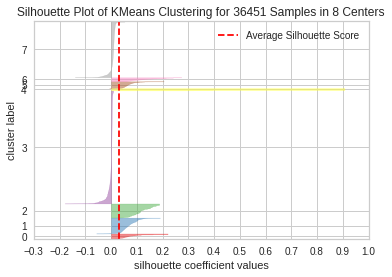

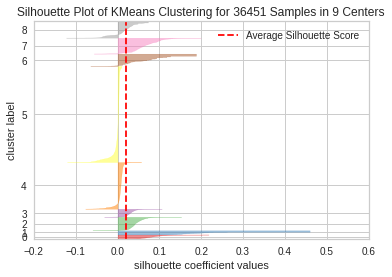

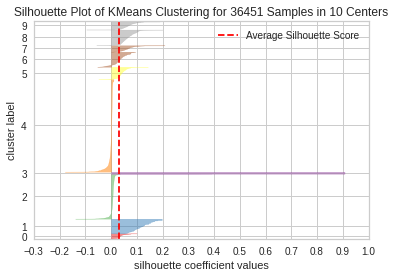

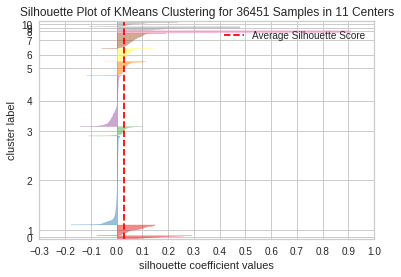

In [30]:
from yellowbrick.cluster import silhouette_visualizer
for k in range(2,12):
    viz = silhouette_visualizer(KMeans(k, random_state=1337), prod_title_d_matrix_2012)

### Transforming the dataset using TruncatedSVD

In [78]:
try:
    try:
        start_time = time.time()
        tsvd_prod_title_2012 = load_pkl('tsvd_prod_title_2012.pkl')
        end_time = time.time()
        
        save_pkl(end_time-start_time, 'TruncatedSVD_runtime_dec2012')

    except:
        tsvd = TruncatedSVD(n_components=prod_title_d_matrix_2012.shape[1])
        tsvd_prod_title_2012 = tsvd.fit(prod_title_d_matrix_2012)
        save_pkl(tsvd_prod_title_2012, 'tsvd_prod_title_2012.pkl')
        
        # sv_idx = np.argsort(tsvd_prod_title_2012.explained_variance_ratio_)[::-1]
        # transformed_2012 = tsvd_prod_title_2012[:, sv_idx]

        # pkl_save(tsvd_prod_title_2012, 'tsvd_prod_title_2012_unsorted')
        # pkl_save(transformed_2012, 'tsvd_prod_title_2012.pkl')
        # pkl_save(sv_idx, 'tsvd_sorting_index_2012')
        
        
except MemoryError():
    sys.exit()

In [79]:
explained_var= tsvd_prod_title_2012.explained_variance_ratio_
explained_var[:10]

array([0.01869151, 0.01087011, 0.01053575, 0.01042505, 0.00895531,
       0.00741009, 0.00681503, 0.00656615, 0.00627079, 0.00594936])

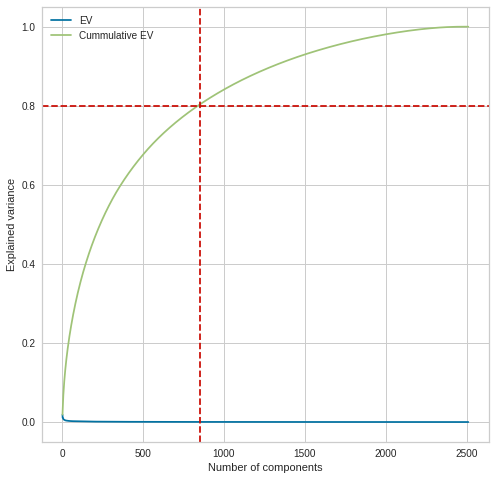

In [85]:
# Make a scree plot
plt.figure(figsize=(8, 8))
n_components = np.arange(1, len(explained_var)+1)
plt.plot(n_components, explained_var, label='EV')
plt.plot(n_components, explained_var.cumsum(), label='Cummulative EV')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
# plt.title("Explained Variance of tSVD-transformed Dataset")

# drawing horizontal and vertical lines
plt.axvline(x=850, color='r', linestyle='--')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.legend()

plt.savefig('img/ScreePlot_prod_title_dec2012.png')
plt.show()

Based on the scree plot, if we keep the first 850 components of the SVD-transformed dataset, we would still retain 80% of the explained variance....

In [87]:
try:
    start_time = time.time()
    tsvd_prod_title_2012_n = load_pkl('tsvd_prod_title_2012_n.pkl')
    end_time = time.time()
    
    save_pkl(end_time-start_time, 'TruncatedSVD_runtime_dec2012.pkl')

except:
    n_comp = 1225
    tsvd_n = TruncatedSVD(n_components=n_comp)
    tsvd_prod_title_2012_n = tsvd_n.fit_transform(prod_title_d_matrix_2012)
    save_pkl(tsvd_prod_title_2012_n, 'tsvd_prod_title_2012_n.pkl')
    
    # Sort indices
    # sv_idx_n = np.argsort(tsvd_prod_title_2012_n.explained_variance_ratio_)[::-1]
    # transformed_2012_n = tsvd_prod_title_2012_n[:, sv_idx]

    # save_pkl(tsvd_prod_title_2012_n, 'tsvd_prod_title_2012_unsorted.pkl')
    # save_pkl(transformed_2012_n, 'tsvd_prod_title_2012_n.pkl')
    # save_pkl(sv_idx_n, 'sorting_index_n_2012.pkl') 

Scatterplot of tSVD-transformed data

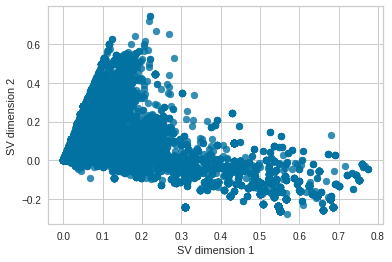

In [88]:
scatter0 = plt.scatter(tsvd_prod_title_2012_n[:, 0],
                       tsvd_prod_title_2012_n[:, 1],
                       cmap='Dark2',
                       alpha=0.8)
plt.xlabel('SV dimension 1')
plt.ylabel('SV dimension 2')
# plt.title(f'Scatterplot of tSVD-transformed Data')

plt.savefig('img/TruncSVDPlot_prod_title_dec2012.png')
plt.show();

### Scatterplot using the best `k-values` found

In [89]:
def plot_km(k, data, rs=1337):
    start_time = time.time()
    km = KMeans(k, random_state=rs)
    km.fit(data)
    save_pkl(km, f'KMeansClusterPlot_k{k}_dec2012.pkl')
    
    scatter1 = plt.scatter(tsvd_prod_title_2012_n[:, 0],
                           tsvd_prod_title_2012_n[:, 1],
                           c=km.labels_,
                           cmap='Dark2')
    save_pkl(scatter1.legend_elements(), f'KMeansClusterPlot_k{k}_legend_ele_dec2012.pkl')
    plt.legend(*scatter1.legend_elements())
    plt.xlabel('SV dimension 1')
    plt.ylabel('SV dimension 2')
    # plt.title(f'Clusters Found Using K-Means, k={k}')
    plt.savefig(f'img/KMeansScatterPlot_k{k}_dec2012.png');
    end_time = time.time()
    
    save_pkl(end_time-start_time, f'KMeansClusterPlot_k{k}_runtime_dec2012.pkl')
    
    return scatter1

In [90]:
best_ks_km = [8, 3, 2]

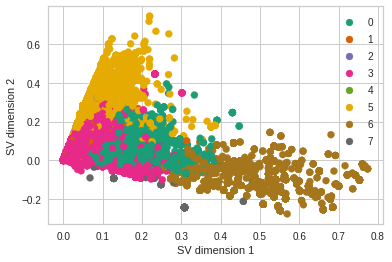

In [104]:
plot_km(k=8, data = tsvd_prod_title_2012_n)

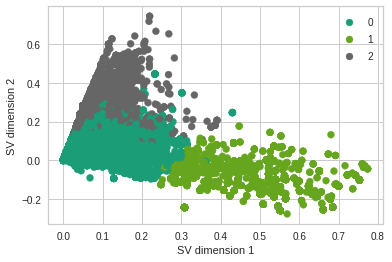

In [105]:
plot_km(k=3, data = tsvd_prod_title_2012_n)

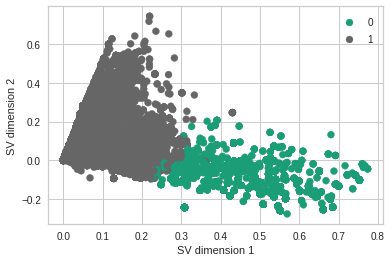

In [106]:
plot_km(k=2, data = tsvd_prod_title_2012_n)

Best number of clusters found: 7. Although the plot for two clusters was cleaner than the rest, for the use case, this is not very practical.

### Visualizing the Clusters

In [107]:
# Get clusters

true_k = 8

start_time = time.time()
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=600, n_init=10)
model.fit(prod_title_d_matrix_2012)
save_pkl(model, 'final_knn_model_2012.pkl')

# Get prediction/labels
labels = model.labels_

title_cl = pd.DataFrame(list(zip(amz_2012['product_title'], labels)), 
                       columns=['title', 'cluster'])
save_pkl(title_cl, 'prod_title_cluster_2012.pkl')
end_time = time.time()

save_pkl(end_time - start_time, 'KMeans_best_k_runtime_dec2012.pkl')

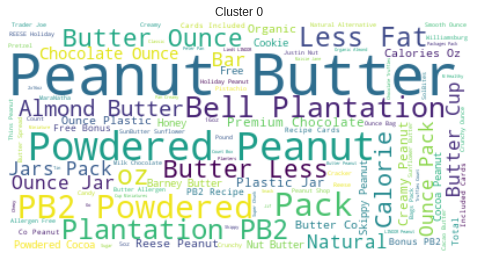

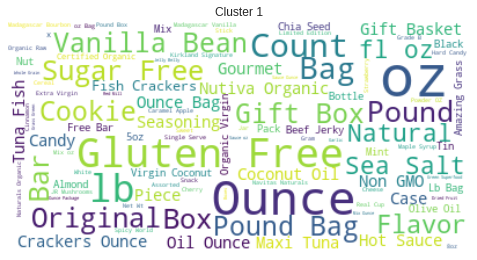

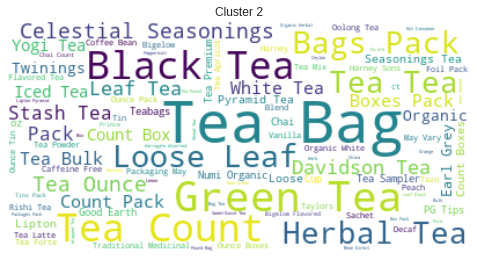

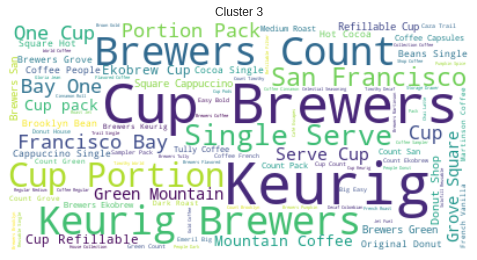

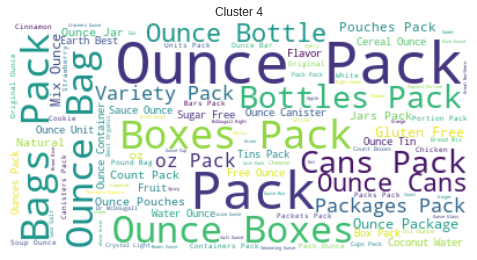

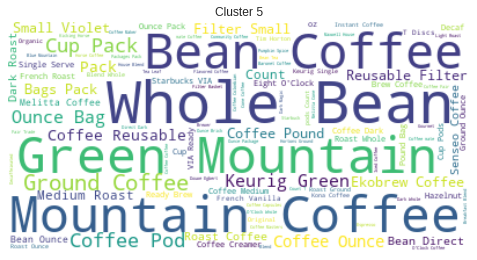

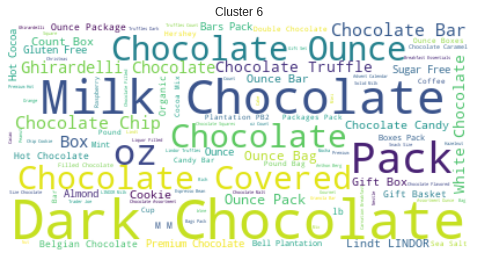

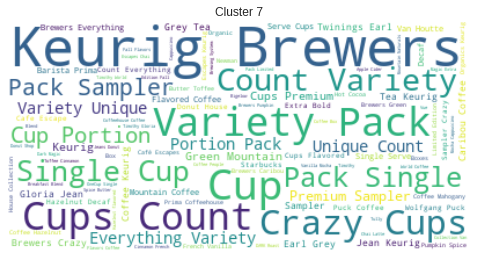

In [108]:
# Visualize the clusters
# Create wordclouds from clusters
from wordcloud import WordCloud

for k in range(true_k):
    start_time = time.time()
    text = title_cl[title_cl.cluster == k].title.str.cat(sep=' ')
    wordcloud = WordCloud(max_font_size=50, max_words=100, 
                          background_color='white').generate(text)
    
    # Create subplot
    plt.figure(figsize=(40, 40))
    plt.subplot(true_k, 2, k+1).set_title('Cluster ' + str(k))
    plt.plot()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig('img/wordcloud_dec2012.png')
    end_time = time.time()
    
    save_pkl(end_time - start_time, 'wordcloud_runtime_dec2012.pkl')
plt.show()


- cluster0 - Peanut Butter
- cluster1 - healthy options
- cluster2 - tea
- cluster3 - ground coffee
- cluster4 - packed items
- cluster5 - coffee beans
- cluster6 - chocolate
- cluster7 - brewing accesories

### Count Vectorizer (unsucessful attempt)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_grams(docs, n=2):
    v = CountVectorizer(ngram_range=(n, n))
    grams = v.fit_transform(docs)
    gram_sum = np.array(np.sum(grams, axis=0)).flatten()
    gram_dict = {i: v for v, i in v.vocabulary_.items()}
    top_grams = gram_sum.argsort()[::1]
    
    return [gram_dict[i] for i in top_grams], gram_sum[top_grams]

In [39]:
doc = ' '.join(df_lemmatized_title_2012['product_title'])

In [40]:
doc[:100]

'chocolate river stones lb bag dave gourmet ultimate insanity hot sauce ounce class bottles pack krus'

In [55]:
ngrams, ngram_counts = {}, {}
for n in [1, 2, 3]:
    #ngrams[n], ngram_counts[n] = get_top_grams[lemmatized_text], n=n
    ngrams[n], ngram_counts[n] = get_top_grams([doc], n=n)

In [56]:
from scipy.stats import zipf
def make_zipf_plot(counts, tokens, a=1.15):
    ranks = np.arange(1, len(counts) + 1)
    indices = np.argsort(-counts)
    normalized_frequencies = counts[indices] / sum(counts)
    f = plt.figure(figsize=(8, 8))
    plt.loglog(ranks, normalized_frequencies, marker=".")
    
    plt.loglog(ranks, [z for z in zipf.pmf(ranks, a)])
    
    plt.title("Zipf Plot")
    plt.xlabel("Word frequency rank")
    plt.ylabel("Word frequency")
    
    ax = plt.gca()
    ax.set_aspect('equal') # make the plot square
    plt.grid(True)
    
    # add text labels
    last_freq = None
    labeled_word_idxs = list(np.logspace(-0.5,
                                         np.log10(len(counts) - 1),
                                         10).astype(int))
    for i in labeled_word_idxs:
        dummy = plt.text(ranks[i],
                         normalized_frequencies[i],
                         " " + tokens[indices[i]],
                         verticalalignment="bottom",
                         horizontalalignment="left")
    plt.show()

In [59]:
ngram_counts

{1: array([    1,     1,     1, ...,  8498,  9914, 12070]),
 2: array([   1,    1,    1, ..., 1326, 1423, 2035]),
 3: array([   1,    1,    1, ...,  547,  592, 1130])}

## Hierarchical Clustering (impractical due to large no. of data points)

In [ ]:
# dense_2012 = d_matrix_2012.to_dense()

In [ ]:
# aggloclustering

#sum_of_squared_distances = []
#K = range(2, 20)

#for k in K:
#    aglo = fastcluster.ward(n_clusters=k, max_iter=600, n_init=10)
#    km.fit(d_matrix_2012)
#    sum_of_squared_distances.append(km.inertia_)

### Finding `k` Using `kelbow_visualizer`

Ward's Method (crashed)

In [ ]:
viz = kelbow_visualizer(AgglomerativeClustering(),
                        dense_2012,
                        k=(2, 20),
                        linkage='ward',
                        show=False)

Complete Linkage Method (crashed)

In [ ]:
viz = kelbow_visualizer(AgglomerativeClustering(),
                        dense_2012,
                        k=(2, 20),
                        linkage='complete',
                        show=False)

Average Method

In [ ]:
try:
    viz = kelbow_visualizer(AgglomerativeClustering(),
                            dense_2012,
                            k=(2, 20),
                            linkage='average',
                            show=False)
except MemoryError():
    sys.exit()
    

Single-linkage Method (crashed)

In [ ]:
viz = kelbow_visualizer(AgglomerativeClustering(),
                        dense_2012,
                        k=(2, 20),
                        linkage='single',
                        show=False)

Function for the hierarchical clustering visualizer

In [ ]:
def viz_agglo_elbow(data, linkage='single', k=(2, 20)):
    """
    Find the score elbow for agglomerative clustering using the 
    `kelbow_visualizer` library and generate corresponding elbow plot. 
    """
    viz = kelbow_visualizer(AgglomerativeClustering(), 
                            data, k,linkage=linkage, show=False)
    return viz

### Finding `k` using dendrograms

Ward's Method (interrupted... too long to run)

In [ ]:
dendrogram(fastcluster.linkage(d_matrix_2012, method='ward'), 
           truncate_mode='lastp', 
           #method='ward', 
           p=5,
           optimal_order=False
          )
plt.xlabel('points in cluster')
plt.ylabel('depth')

Complete Linkage Method

In [ ]:
dendrogram(linkage(d_matrix_2012), truncate_mode='lastp', 
            method='complete', p=5)
plt.xlabel('points in cluster')
plt.ylabel('depth')

Average Linkage Method

In [ ]:
dendrogram(linkage(d_matrix_2012), truncate_mode='level', 
            method='average', p=5)
plt.xlabel('points in cluster')
plt.ylabel('depth')

Single-linkage Method

In [ ]:
dendrogram(linkage(d_matrix_2012), truncate_mode='level', 
            method='single', p=5)
plt.xlabel('points in cluster')
plt.ylabel('depth')

The best `k` value found was xx using yy method.

### Scatterplot using the best `k` found

In [ ]:
best_k_ac = 6

In [ ]:
ac = AgglomerativeClustering(n_clusters=best_k_ac)
ac.fit(d_matrix_2012.to_numpy())

In [ ]:
scatter2 = plt.scatter(tsvd_2012_n[:, 0],
                       tsvd_2012_n[:, 1],
                       c=ac.labels_,
                       cmap='Dark2')
plt.legend(*scatter2.legend_elements())
plt.xlabel('SV dimension 1')
plt.ylabel('SV dimension 2')
plt.title(f'Clusters Found Using Agglomerative Methods, best k={best_k_ac}')
plt.show();

## Density-based Clustering

### DBSCAN

In [ ]:
try:
    core_points = d_matrix_2012.shape[1] * 2
    nn = NearestNeighbors(n_neighbors=core_points + 1)
    nn = nn.fit(d_matrix_2012)
    distances, neighbors = nn.kneighbors(d_matrix_2012)
    average_distances = distances[:, 1:].mean(axis=1)
    average_distances = np.sort(average_distances)
    
    plt.plot(average_distances)
    plt.xlabel('point number')
    plt.ylabel(f'average distance to {core_points} neighbors')
    plt.show();
    
except MemoryError():
    sys.exit()

In [ ]:

kneedle = KneeLocator(range(average_distances.shape[0]),
                      average_distances,
                      curve="concave",
                      direction="increasing")

kneedle.plot_knee()
plt.xlabel('point number')
plt.ylabel(f'average distance to {core_points} neighbors')
plt.show();

eps = average_distances[kneedle.knee]


In [ ]:
print(f'epsilon: {eps}, point no.: {kneedle.knee}')

In [ ]:
try:
    
    db = DBSCAN(eps=eps, min_samples=d_matrix_2012.shape[1]*2, n_jobs=-1)
    db.fit(d_matrix_2012)
    
except MemoryError():
    sys.exit()

In [ ]:
try:

    cluster_labels = db.fit_predict(tsvd_2012_n)
    scatter3 = plt.scatter(tsvd_2012_n[:, 0], 
                           tsvd_2012_n[:, 1], 
                           c=cluster_labels, 
                           cmap='Dark2', s=40)
    plt.legend(*scatter3.legend_elements())
    plt.xlabel('SV dimension 1')
    plt.ylabel('SV dimension 2')
    plt.title(f'Clusters Found Using DBSCAN, k={cluster_labels.max()+1}')

    print('Number of clusters:', cluster_labels.max()+1)
    print('Number of noise points:', (cluster_labels==-1).sum())
    print('Number of points:', len(cluster_labels))
    
except MemoryError():
    sys.exit()
